In [1]:
import yfinance
import numpy as np
import pandas as pd

In [2]:
TICKER = "INFY"
data = yfinance.download(TICKER+".NS", period="8mo")

[*********************100%***********************]  1 of 1 completed


In [3]:
rs_val = []
def getRelativeStrength(arr):
    from functools import reduce
    changes = [arr[i]-arr[i-1] for i in range(1,len(arr))]
    close_up_sum = sum(c for c in changes if c > 0)/len(arr)
    close_down_sum = sum(abs(c) for c in changes if c < 0)/len(arr)
    
    return close_up_sum/close_down_sum

def getRelativeStrengthIndex(ds):
    maxLen = ds.shape[0]
    n_period = 15
    rsind = {}
    
    for i in range(n_period, maxLen):
        curr_date = str(ds.index[i])
        rs = getRelativeStrength(ds.values[i-n_period:i])
        rsind[str(i)] = 100 - (100/(1+rs))
        rs_val.append([i, rs])
    
    return rsind

In [4]:
d = data['Close']

In [5]:
rsi = getRelativeStrengthIndex(d)

In [6]:
from random import randint
import random

random.seed(10)

shares_bought = 0
shares_sold = 0
shares = 0
history = []
profit = 0
overbought, oversold = 70,30
totalBuy, totalSell = 0,0


for i in range(data.shape[0]):
    if str(i) in rsi.keys():
        #decide whether to buy, sell or stay put
        if rsi[str(i)] <= oversold:
            buy_shares = randint(1,10)
            curr_price = data.iloc[i]['Open']
#             profit -= curr_price*buy_shares
            totalBuy += curr_price*buy_shares
            shares += buy_shares
            shares_bought += buy_shares
            history.append((i, data.iloc[i].name, 'buy', buy_shares, shares))
        elif rsi[str(i)] >= overbought:
            if shares > 0:
                sell_shares = randint(1, shares)
                curr_price = data.iloc[i]['Open']
#                 profit += curr_price*sell_shares
                totalSell += curr_price*sell_shares
                shares -= sell_shares
                shares_sold += sell_shares
                history.append((i, data.iloc[i].name, 'sell', sell_shares, shares))

totalProfit = totalSell - totalBuy

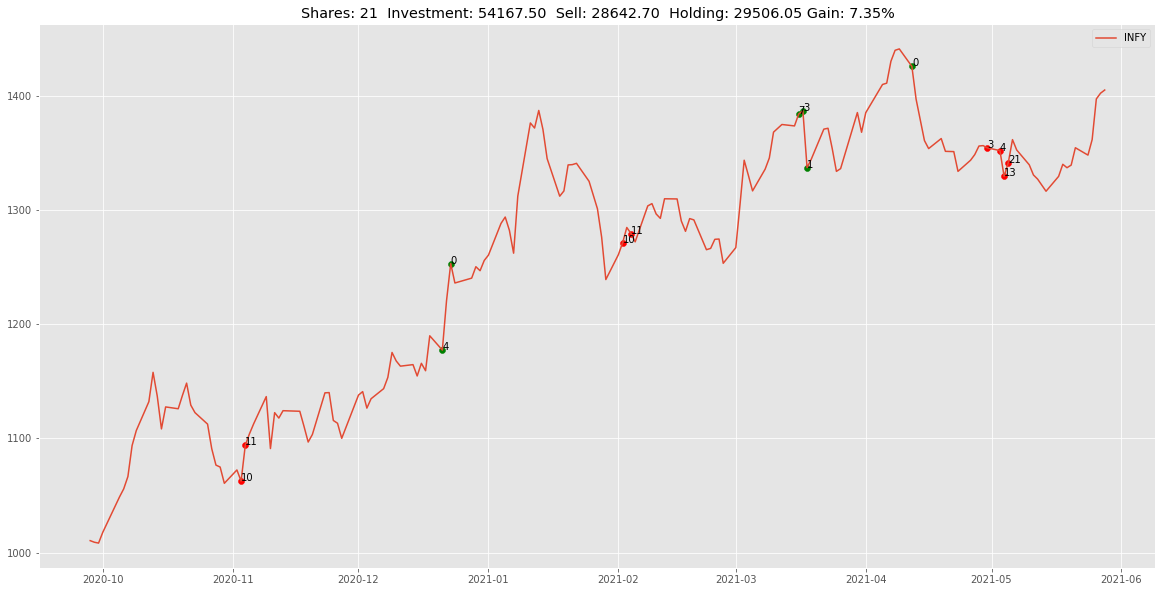

In [8]:
import matplotlib.pyplot as plt

buy_plot = np.array([[h[1], data.iloc[h[0]]['Close'], h[-1]] for h in history if h[2] == 'buy'])
sell_plot = np.array([[h[1], data.iloc[h[0]]['Close'], h[-1]] for h in history if h[2] == 'sell'])
holding = shares*data.iloc[-1]['Close']

plt.style.use('ggplot')
plt.figure(figsize=(20,10))
plt.plot(data['Close'].index, data['Close'].values, label=TICKER)
plt.scatter(buy_plot[:,0], buy_plot[:,1], c='red')
for i,s in enumerate(buy_plot[:,2]):
    plt.annotate(str(s), (buy_plot[i,0],buy_plot[i,1]))
plt.scatter(sell_plot[:,0], sell_plot[:,1], c='green')
for i,s in enumerate(sell_plot[:,2]):
    plt.annotate(str(s), (sell_plot[i,0],sell_plot[i,1]))
plt.title(f"Shares: {shares}  Investment: {totalBuy:.2f}  Sell: {totalSell:.2f}  Holding: {holding:.2f} Gain: {(holding+totalSell-totalBuy)/totalBuy*100:.2f}%")
plt.legend()
plt.show()